# Análise de Mercado Imobiliário

**Objetivo:** 
Estimar o preço médio por m² de forma segmentada (por porte do imóvel e década de construção), indo além da média simples para encontrar uma avaliação que se aproxima da realidade utilizando dados públicos de transações reais (ITBI) e cadastro fiscal (IPTU).Trata-se de apenas estudo estatístico, não uma avaliação oficial.

**Contexto:** Este é um projeto pessoal, feito por alguém que não é especialista no tema, mas que busca uma base de clareza e autonomia na percepção de mercado, utilizando o poder do python e de dados públicos. 

**Benefício:** A grande beleza deste projeto é que ele é um ponto de partida de código aberto e pode ajudar outras pessoas. Se você desejar analisar seu próprio bairro, lembre-se: precisará adaptar o código, os critérios de limpeza e os filtros para a sua realidade. Este é um convite para a exploração e o aprendizado! :)

**Metodologia:**
1. Coleta e consolidação de dados públicos da Prefeitura de São Paulo.
2. Limpeza e padronização de endereços e tipos de imóveis.
3. Engenharia de dados para fusão de registros (Apartamentos + Garagens).
4. Segmentação analítica por porte e idade do imóvel.

**Desafio:**
Bases públicas são ricas, mas necessitam de tratamento: Normalizar endereços/nomes e,associar apartamentos aos valores de suas vagas de garagem (que, se vendidas separadamente, precisam ter o valor somado para se ter o preço real do imóvel por m²) e decidir como tratar vendas parciais. Este caderno traz decisões de limpeza e filtragem simples(evitando outliers, removendo vendas parciais) para conseguir uma amostra relevante, não exaustivas voltadas para o bairro de analise. Lembre-se este projeto é um estudo, não um laudo oficial. 

**Fonte:**
A base para esta jornada analítica são os dados públicos de ITBI (Imposto sobre a Transmissão de Bens Imóveis) e informações cadastrais do IPTU, disponibilizados pela Prefeitura de São Paulo. Os dados de ITBI são públicos e podem ser baixados no portal da Prefeitura, na seção de Acesso à Informação.
Link para a base original (Prefeitura de São Paulo): https://prefeitura.sp.gov.br/web/fazenda/w/acesso_a_informacao/31501

⚠️ **Importante**⚠️: 
1. Este projeto não se propõe a ser um laudo oficial. Se você não tem familiaridade com análises de dados ou precisa de um valor com precisão legal ou profissional, é fundamental buscar a consultoria adequada de um profissional da área de avaliação imobiliária.
2. Este estudo foi realizado exclusivamente para fins educacionais e de demonstração de técnicas de engenharia de dados. Todos os dados utilizados são públicos e foram tratados para remover informações sensíveis, conforme boas práticas de privacidade.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata

# Configurações de exibição
sns.set_theme(style="whitegrid") #fundo branco
pd.set_option('display.float_format', lambda x: '%.2f' % x) #decimal com duas casas
pd.set_option('display.max_columns', None) #mostra todas as colunas

# Parâmetros do Projeto
ARQUIVO_EXCEL = 'GUIAS DE ITBI PAGAS XLS 28102025.xlsx'
BAIRROS_ALVO = [
    'VILA SANTA CATARINA', 'VILA STA CATARINA', 'V. SANTA CATARINA',
    'VL SANTA CATARINA', 'VL STA CATARINA', 'VL STA. CATARINA'
]
PADRAO_ABA_MES = re.compile(r'^[A-Z]{3,4}-\d{4}$')

# Definição de Schema (Colunas essenciais para garantir a consistência entre abas)
COLUNAS_TARGET = [
    'N° do Cadastro (SQL)', 'Nome do Logradouro', 'Número', 'Complemento',
    'Bairro', 'Referência', 'CEP', 'Natureza de Transação',
    'Valor de Transação (declarado pelo contribuinte)', 'Data de Transação',
    'Valor Venal de Referência', 'Proporção Transmitida (%)',
    'Valor Venal de Referência (proporcional)', 'Base de Cálculo adotada',
    'Tipo de Financiamento', 'Valor Financiado', 'Cartório de Registro',
    'Matrícula do Imóvel', 'Situação do SQL', 'Área do Terreno (m2)',
    'Testada (m)', 'Fração Ideal', 'Área Construída (m2)',
    'Uso (IPTU)', 'Descrição do uso (IPTU)',
    'Padrão (IPTU)', 'Descrição do padrão (IPTU)',
    'ACC (IPTU)', 'ACC (IPTU).1'
]

def limpar_nome_coluna(nome):
    """Padroniza nomes de colunas (minúsculo, sem acento, sem espaços)."""
    if pd.isna(nome): return ""
    nfkd = unicodedata.normalize('NFKD', str(nome))
    limpo = "".join([c for c in nfkd if not unicodedata.combining(c)])
    return re.sub(r'[^\w]', '', limpo).lower()

def carregar_dados():
    print(">>> Iniciando carga e consolidação de dados...")
    dfs = []
    try:
        excel = pd.ExcelFile(ARQUIVO_EXCEL)
        for aba in excel.sheet_names:
            if not PADRAO_ABA_MES.match(aba): continue

            dft = pd.read_excel(excel, sheet_name=aba)

            # Normalização de colunas para garantir o schema
            dft.columns = dft.columns.str.strip()
            for col in COLUNAS_TARGET:
                if col not in dft.columns: dft[col] = np.nan
            dft = dft[COLUNAS_TARGET]

            # Tratamento da coluna Ano de Construção (ACC)
            # Prioriza ACC (IPTU).1 se existir dados, caso contrário usa ACC (IPTU)
            acc1_numeric = pd.to_numeric(dft['ACC (IPTU).1'], errors='coerce')
            if not acc1_numeric.isnull().all():
                dft['ACC_FINAL'] = acc1_numeric.fillna(dft['ACC (IPTU)'])
            else:
                dft['ACC_FINAL'] = dft['ACC (IPTU)']

            dft = dft.drop(columns=['ACC (IPTU)', 'ACC (IPTU).1'])
            dft.columns = [limpar_nome_coluna(col) for col in dft.columns]
            dft['mes_ref'] = aba
            dfs.append(dft)

        if not dfs: return pd.DataFrame()

        df = pd.concat(dfs, ignore_index=True)

        # Filtro de Bairro e Conversão de Tipos
        df['bairro'] = df['bairro'].astype(str).str.upper().str.strip()
        df = df[df['bairro'].isin(BAIRROS_ALVO)].copy()

        df['datadetransacao'] = pd.to_datetime(df['datadetransacao'], errors='coerce')
        df['valordetransacaodeclaradopelocontribuinte'] = pd.to_numeric(df['valordetransacaodeclaradopelocontribuinte'], errors='coerce')
        df['areaconstruidam2'] = pd.to_numeric(df['areaconstruidam2'], errors='coerce')

        # Remove registros sem valor ou área (essenciais para o cálculo do m²)
        df.dropna(subset=['valordetransacaodeclaradopelocontribuinte', 'areaconstruidam2'], inplace=True)

        print(f">>> Carga concluída. Total de registros processados: {len(df)}")
        return df

    except Exception as e:
        print(f"Erro no processamento: {e}")
        return pd.DataFrame()

# Execução
df_bruto = carregar_dados()

>>> Iniciando carga e consolidação de dados...
>>> Carga concluída. Total de registros processados: 125


In [27]:
# ==============================================================================
# CLASSIFICAÇÃO E HIGIENIZAÇÃO
#
# Objetivos:
# 1. Categorizar os imóveis (Apartamento, Casa, Terreno, Garagem).
# 2. Remover ruídos: vendas parciais (<99%) e valores simbólicos (< R$ 10k).
# ==============================================================================

# Cópia de trabalho
df_analise = df_bruto.copy()
total_registros = len(df_analise)

# --- 1. Classificação Semântica ---
def classificar_imovel(linha):
    """Define o tipo do imóvel com base na descrição do IPTU."""
    desc = str(linha.get('descricaodousoiptu', '')).upper()
    desc_padrao = str(linha.get('descricaodopadraoiptu', '')).upper()
    padrao = str(linha.get('padraoiptu', '')).upper()

    # Ordem de prioridade
    if any(x in desc for x in ['GARAGEM', 'ESTACIONAMENTO', 'VAGA', 'BOX']):
        return 'Garagem'
    elif any(x in desc for x in ['LOJA', 'COMERCIAL', 'ESCRITÓRIO', 'CONSULTÓRIO']):
        return 'Comercial'
    elif 'TERRENO' in desc:
        return 'Terreno'
    elif any(x in desc for x in ['APARTAMENTO', 'FLAT']) or 'VERTICAL' in desc_padrao:
        return 'Apartamento'
    elif any(x in desc for x in ['RESIDÊNCIA', 'CASA']):
        # Correção: Casas cadastradas em condomínio vertical geralmente são apartamentos
        if 'VERTICAL' in desc_padrao or padrao.startswith('2'):
            return 'Apartamento'
        return 'Casa'
    else:
        return 'Outros'

print(">>> Classificando imóveis...")
df_analise['tipo_imovel'] = df_analise.apply(classificar_imovel, axis=1)

# --- 2. Filtragem de Ruído (Limpeza) ---
print(">>> Aplicando filtros de consistência...")

# Regra 1: Remover vendas parciais (ex: venda de 50% do imóvel)
if 'proporcaotransmitida' in df_analise.columns:
    df_analise = df_analise[df_analise['proporcaotransmitida'] >= 99.0]

# Regra 2: Remover valores irrisórios (erros ou doações simbólicas)
df_analise = df_analise[df_analise['valordetransacaodeclaradopelocontribuinte'] >= 10000]

# --- Resultados ---
removidos = total_registros - len(df_analise)
print(f"Registros removidos (inconsistentes/parciais): {removidos} ({removidos/total_registros:.1%})")
print(f"Base final para análise: {len(df_analise)} registros")

print("\nDistribuição por Tipo:")
print(df_analise['tipo_imovel'].value_counts())

>>> Classificando imóveis...
>>> Aplicando filtros de consistência...
Registros removidos (inconsistentes/parciais): 40 (32.0%)
Base final para análise: 85 registros

Distribuição por Tipo:
tipo_imovel
Apartamento    49
Casa           18
Garagem        12
Terreno         3
Outros          2
Comercial       1
Name: count, dtype: int64


In [28]:
# ==============================================================================
# NORMALIZAÇÃO DE ENDEREÇOS (AGORA COM BAIRRO REFINADO!)
#
# Objetivo: Padronizar Rua, Número e Bairro para permitir o cruzamento (fusão).
# Correção: Normalização mais agressiva para variações de "Vila", "Santa", etc.
# ==============================================================================

def normalizar_texto(texto):
    """
    Remove acentos, pontuação e padroniza abreviações.
    Ex: 'Vila Santa Catarina' -> 'VL STA CATARINA'
    """
    if pd.isna(texto): return ""
    
    # 1. Desmonta caracteres acentuados (ex: 'ã' vira 'a' + '~')
    nfkd = unicodedata.normalize('NFKD', str(texto))
    
    # 2. Filtra apenas os caracteres base (descarta os acentos) e põe em Maiúscula
    txt = "".join([c for c in nfkd if not unicodedata.combining(c)]).upper()
    
    # 3. Remove pontuação (troca por espaço)
    txt = txt.replace('.', ' ').replace(',', ' ').replace('-', ' ').replace('/', ' ')
    
    # 4. Padronização de Termos Comuns (Regex)
    # \b garante que só substitua a palavra inteira
    
    # Tipos de Logradouro
    txt = re.sub(r'\bRUA\b', 'R', txt)
    txt = re.sub(r'\bAVENIDA\b', 'AV', txt)
    txt = re.sub(r'\bALAMEDA\b', 'AL', txt)
    txt = re.sub(r'\bTRAVESSA\b', 'TV', txt)
    txt = re.sub(r'\bESTRADA\b', 'EST', txt)
    txt = re.sub(r'\bPRACA\b', 'PC', txt)
    
    # Bairros e Títulos (AQUI ESTÁ A CORREÇÃO PRINCIPAL)
    txt = re.sub(r'\bVILA\b', 'VL', txt)
    txt = re.sub(r'\bV\b', 'VL', txt)      # Pega "V." que virou "V " após remover pontuação
    txt = re.sub(r'\bSANTA\b', 'STA', txt) # Padroniza Santa -> STA
    txt = re.sub(r'\bSANTO\b', 'STO', txt)
    txt = re.sub(r'\bSAO\b', 'SAO', txt)   # Mantém SAO sem til
    txt = re.sub(r'\bJARDIM\b', 'JD', txt)
    txt = re.sub(r'\bPARQUE\b', 'PQ', txt)
    txt = re.sub(r'\bDOUTOR\b', 'DR', txt)
    txt = re.sub(r'\bPROFESSOR\b', 'PROF', txt)
    
    # Complementos
    txt = re.sub(r'\bAPARTAMENTO\b', 'AP', txt)
    txt = re.sub(r'\bAPTO\b', 'AP', txt)
    txt = re.sub(r'\bVAGA\b', 'VG', txt)
    txt = re.sub(r'\bGARAGEM\b', 'VG', txt)
    txt = re.sub(r'\bBOX\b', 'VG', txt)
    
    # Remove espaços duplos criados pela limpeza
    return " ".join(txt.split())

def normalizar_numero(x):
    """Padroniza números (remove zeros à esquerda, trata S/N)."""
    if pd.isna(x) or x == 0: return "SN"
    s = str(x).upper().replace('.', '').replace(',', '').strip()
    if s.isdigit(): return str(int(s)) # "050" vira "50"
    return s

print(">>> Normalizando endereços (Logradouro, Bairro e Complemento)...")

# Aplica a função em todas as colunas de endereço
df_analise['logradouro_norm'] = df_analise['nomedologradouro'].apply(normalizar_texto)
df_analise['bairro_norm'] = df_analise['bairro'].apply(normalizar_texto)
df_analise['complemento_norm'] = df_analise['complemento'].apply(normalizar_texto)
df_analise['numero_norm'] = df_analise['numero'].apply(normalizar_numero)


print("Exemplo de Normalização:")
display(df_analise[['bairro', 'bairro_norm']].head(3))

>>> Normalizando endereços (Logradouro, Bairro e Complemento)...
Exemplo de Normalização:


,bairro,bairro_norm
3228,VL STA CATARINA,VL STA CATARINA
6611,VILA SANTA CATARINA,VL STA CATARINA
8204,VL SANTA CATARINA,VL STA CATARINA


In [29]:
# ==============================================================================
# MOTOR DE FUSÃO (PROCESSAMENTO)
#
# O QUE FAZ:
# 1. Cria a chave única (Rua + Número + Data).
# 2. Identifica pacotes "Apartamento + Garagem" comprados juntos.
# 3. Soma o valor das garagens ao valor do apartamento.
# 4. Salva tudo em memória (df_analise) sem exibir dados sensíveis.
# ==============================================================================

def fundir_garagens_robusto(df):
    df_work = df.copy()
    
    print(">>> [MOTOR] Iniciando algoritmo de fusão...")
    
    # Garantia de Data
    df_work['datadetransacao'] = pd.to_datetime(df_work['datadetransacao'], errors='coerce')
    
    # 1. CRIAÇÃO DA CHAVE DE FUSÃO
    df_work['id_fusao'] = (
        df_work['logradouro_norm'] + "_" + 
        df_work['numero_norm'].astype(str) + "_" + 
        df_work['datadetransacao'].dt.strftime('%Y-%m-%d')
    )
    
    registros_finais = []
    sobras = []
    stats = {'Fundidos': 0, 'Originais': 0, 'Sobras': 0}
    
    # 2. LOOP DE AGRUPAMENTO
    # Agrupa por endereço+data para ver quem comprou o que junto
    for id_evento, grupo in df_work.groupby('id_fusao'):
        
        aptos = grupo[grupo['tipo_imovel'] == 'Apartamento']
        garagens = grupo[grupo['tipo_imovel'] == 'Garagem']
        
        # CENÁRIO A: FUSÃO (1 Apto + N Garagens na mesma compra)
        if len(aptos) == 1 and len(garagens) >= 1:
            row_apto = aptos.iloc[0].copy()
            
            # Soma valores
            valor_garagens = garagens['valordetransacaodeclaradopelocontribuinte'].sum()
            valor_original = row_apto['valordetransacaodeclaradopelocontribuinte']
            
            # Atualiza registro
            row_apto['valor_original'] = valor_original
            row_apto['valor_garagens_somadas'] = valor_garagens
            row_apto['valordetransacaodeclaradopelocontribuinte'] = valor_original + valor_garagens
            row_apto['status_fusao'] = 'FUNDIDO'
            
            registros_finais.append(row_apto.to_dict())
            stats['Fundidos'] += 1
            
            # Se tiver outros itens no pacote (ex: terreno), salva separado
            outros = grupo[~grupo['tipo_imovel'].isin(['Apartamento', 'Garagem'])]
            if not outros.empty: registros_finais.extend(outros.to_dict('records'))

        # CENÁRIO B: SEM FUSÃO (Apto sozinho ou Garagem avulsa)
        else:
            # Imóveis principais (mantém como está)
            imoveis = grupo[grupo['tipo_imovel'] != 'Garagem']
            for _, row in imoveis.iterrows():
                row['valor_original'] = row['valordetransacaodeclaradopelocontribuinte']
                row['valor_garagens_somadas'] = 0.0
                row['status_fusao'] = 'ORIGINAL'
                registros_finais.append(row.to_dict())
                stats['Originais'] += 1
            
            # Garagens sem dono (sobras)
            sobras.extend(garagens.to_dict('records'))
            stats['Sobras'] += len(garagens)

    # Reconstrói DataFrames
    df_final = pd.DataFrame(registros_finais)
    df_sobras = pd.DataFrame(sobras)
    
    # Recalcula Preço/m² com o valor novo (somado)
    if not df_final.empty:
        df_final['preco_m2'] = np.where(
            df_final['areaconstruidam2'] > 0,
            df_final['valordetransacaodeclaradopelocontribuinte'] / df_final['areaconstruidam2'],
            np.nan
        )

    print(f">>> [MOTOR] Processamento finalizado.")
    print(f"    - Apartamentos Fundidos: {stats['Fundidos']}")
    print(f"    - Imóveis Originais:     {stats['Originais']}")
    print(f"    - Garagens Soltas:       {stats['Sobras']}")
    
    return df_final, df_sobras

# Executa o motor e guarda na memória
# df_analise é a base vinda do bloco anterior
df_analise, df_sobras = fundir_garagens_robusto(df_analise)

>>> [MOTOR] Iniciando algoritmo de fusão...
>>> [MOTOR] Processamento finalizado.
    - Apartamentos Fundidos: 11
    - Imóveis Originais:     61
    - Garagens Soltas:       1


In [30]:
# ==============================================================================
# AUDITORIA VISUAL (DADOS SENSÍVEIS)
#
# ATENÇÃO: Esta célula exibe endereços e valores reais.
# >>> LIMPE O OUTPUT APÓS A CONFERÊNCIA <<<
# ==============================================================================

def exibir_auditoria(df_principal, df_sobras):
    # Filtra apenas os casos onde houve fusão para validar a matemática
    df_sucesso = df_principal[df_principal['status_fusao'] == 'FUNDIDO'].copy()

    if not df_sucesso.empty:
        print("\n>>> AMOSTRA DE FUSÕES REALIZADAS (Valor Apto + Valor Garagem):")
        
        cols_audit = [
            'nomedologradouro', 'numero', 'complemento', 
            'valor_original', 'valor_garagens_somadas', 
            'valordetransacaodeclaradopelocontribuinte'
        ]
        
        view = df_sucesso[cols_audit].rename(columns={
            'valordetransacaodeclaradopelocontribuinte': 'VALOR_FINAL',
            'valor_original': 'APTO',
            'valor_garagens_somadas': 'GARAGEM'
        })

        # Formatação de Moeda
        display(view.head(5).style.format({
            'APTO': 'R$ {:,.2f}',
            'GARAGEM': 'R$ {:,.2f}',
            'VALOR_FINAL': 'R$ {:,.2f}'
        }).background_gradient(cmap='Greens', subset=['VALOR_FINAL']))
    else:
        print("\n(Nenhuma fusão automática ocorreu nesta amostra. Isso é normal se os imóveis foram vendidos sem vaga separada)")

    if not df_sobras.empty:
        print("\n>>> GARAGENS NÃO PAREADAS (Sobras):")
        print("Verifique se o endereço difere do apartamento ou se são vendas avulsas.")
        display(df_sobras[['nomedologradouro', 'numero', 'complemento', 'valordetransacaodeclaradopelocontribuinte']].head(5))

# Mostra os dados
exibir_auditoria(df_analise, df_sobras)


>>> AMOSTRA DE FUSÕES REALIZADAS (Valor Apto + Valor Garagem):


,nomedologradouro,numero,complemento,APTO,GARAGEM,VALOR_FINAL
3,AV JOAO BARRETO DE MENEZES,939,AP71,"R$ 225,000.00","R$ 30,000.00","R$ 255,000.00"
10,R ALBA,2088,AP 14,"R$ 171,000.00","R$ 19,000.00","R$ 190,000.00"
11,R ALBA,2088,AP 31,"R$ 279,000.00","R$ 31,000.00","R$ 310,000.00"
12,R ALBA,2088,AP 34,"R$ 150,543.82","R$ 22,886.01","R$ 173,429.83"
13,R ALBA,2088,AP 35,"R$ 230,000.00","R$ 40,000.00","R$ 270,000.00"



>>> GARAGENS NÃO PAREADAS (Sobras):
Verifique se o endereço difere do apartamento ou se são vendas avulsas.


,nomedologradouro,numero,complemento,valordetransacaodeclaradopelocontribuinte
0,R CONS ELIAS DE CARVALHO,174,GR 42 SUBSOLO,38000.00


In [31]:
# ==============================================================================
# TABELA DE PRECIFICAÇÃO POR PORTE
#
# Objetivo: Segmentar o mercado por tamanho para obter o preço médio do m²
# específico para cada perfil de imóvel.
# ==============================================================================

import pandas as pd

# Definição das faixas de tamanho
BINS_AREA = [0, 50, 65, 85, 100, 150, 9999]
LABELS_PERFIL = [
    '1. Compacto (<50m²)',
    '2. Funcional (50-65m²)',
    '3. Padrão (66-85m²)',
    '4. Amplo (86-100m²)',
    '5. Premium (101-150m²)',
    '6. Alto Padrão (>150m²)'
]

def gerar_tabela_mercado(df):
    # Filtra apenas apartamentos
    df_apto = df[df['tipo_imovel'] == 'Apartamento'].copy()

    # Filtros de segurança (Preço e m² coerentes)
    df_apto = df_apto[
        (df_apto['valordetransacaodeclaradopelocontribuinte'] >= 100000) &
        (df_apto['preco_m2'] >= 2000) &
        (df_apto['preco_m2'] <= 50000)
    ].copy()

    if df_apto.empty:
        print("Não há dados suficientes de apartamentos após a filtragem.")
        return None

    # Segmentação por Perfil
    df_apto['perfil'] = pd.cut(df_apto['areaconstruidam2'], bins=BINS_AREA, labels=LABELS_PERFIL)

    # Agregação (Sem Vagas)
    tabela = df_apto.groupby('perfil', observed=False).agg({
        'valordetransacaodeclaradopelocontribuinte': ['count', 'min', 'max', 'mean'],
        'preco_m2': 'mean'
    })

    # Renomeia colunas
    tabela.columns = ['Qtd Vendas', 'Mínimo (R$)', 'Máximo (R$)', 'Preço Médio (R$)', 'Média m² (R$)']

    # Média Geral Ponderada
    total_valor = df_apto['valordetransacaodeclaradopelocontribuinte'].sum()
    total_area = df_apto['areaconstruidam2'].sum()
    media_ponderada = total_valor / total_area if total_area > 0 else 0

    # Linha de Totais
    linha_geral = pd.DataFrame({
        'Qtd Vendas': [len(df_apto)],
        'Mínimo (R$)': [df_apto['valordetransacaodeclaradopelocontribuinte'].min()],
        'Máximo (R$)': [df_apto['valordetransacaodeclaradopelocontribuinte'].max()],
        'Preço Médio (R$)': [df_apto['valordetransacaodeclaradopelocontribuinte'].mean()],
        'Média m² (R$)': [media_ponderada]
    }, index=['MÉDIA GERAL DO BAIRRO'])

    df_final = pd.concat([tabela, linha_geral])

    # Formatação Visual
    return df_final.style.format({
        'Mínimo (R$)': 'R$ {:,.2f}',
        'Máximo (R$)': 'R$ {:,.2f}',
        'Preço Médio (R$)': 'R$ {:,.2f}',
        'Média m² (R$)': 'R$ {:,.2f}'
    }).background_gradient(cmap='Blues', subset=['Qtd Vendas'])\
      .bar(subset=['Média m² (R$)'], color='#5fba7d', vmin=0)

print(">>> Gerando Tabela de Precificação de Mercado...")
display(gerar_tabela_mercado(df_analise))

>>> Gerando Tabela de Precificação de Mercado...


,Qtd Vendas,Mínimo (R$),Máximo (R$),Preço Médio (R$),Média m² (R$)
1. Compacto (<50m²),0,R$ nan,R$ nan,R$ nan,R$ nan
2. Funcional (50-65m²),1,"R$ 290,000.00","R$ 290,000.00","R$ 290,000.00","R$ 5,087.72"
3. Padrão (66-85m²),6,"R$ 200,000.00","R$ 345,000.00","R$ 271,166.67","R$ 3,326.49"
4. Amplo (86-100m²),11,"R$ 190,000.00","R$ 376,000.00","R$ 286,454.55","R$ 3,041.15"
5. Premium (101-150m²),21,"R$ 221,000.00","R$ 425,000.00","R$ 333,683.90","R$ 2,869.12"
6. Alto Padrão (>150m²),4,"R$ 400,000.00","R$ 760,000.00","R$ 655,000.00","R$ 4,131.59"
MÉDIA GERAL DO BAIRRO,43,"R$ 190,000.00","R$ 760,000.00","R$ 341,752.60","R$ 3,146.76"


In [32]:
# ==============================================================================
# AUDITORIA DE EXEMPLOS (VALIDAÇÃO MICRO)
#
# Objetivo: Listar 3 exemplos reais de cada perfil (Compacto, Padrão, etc.)
# para confirmar se a classificação faz sentido com a realidade do bairro.
# ==============================================================================

def auditar_exemplos(df):
    # Filtra base de apartamentos com os mesmos critérios da tabela
    df_audit = df[
        (df['tipo_imovel'] == 'Apartamento') &
        (df['valordetransacaodeclaradopelocontribuinte'] >= 100000) &
        (df['preco_m2'] >= 2000) &
        (df['preco_m2'] <= 50000)
    ].copy()

    # Recria os perfis para garantir a segmentação
    bins = [0, 50, 65, 85, 100, 150, 9999]
    labels = [
        '1. Compacto (<50m²)', '2. Funcional (50-65m²)', 
        '3. Padrão (66-85m²)', '4. Amplo (86-100m²)', 
        '5. Premium (101-150m²)', '6. Alto Padrão (>150m²)'
    ]
    df_audit['perfil'] = pd.cut(df_audit['areaconstruidam2'], bins=bins, labels=labels)

    # Colunas para visualização
    cols_view = [
        'nomedologradouro', 'numero', 'complemento_norm', 
        'areaconstruidam2', 'valordetransacaodeclaradopelocontribuinte', 'preco_m2'
    ]

    print(">>> AMOSTRA DE IMÓVEIS POR PERFIL <<<")

    for perfil in labels:
        subset = df_audit[df_audit['perfil'] == perfil]
        
        print(f"\n📂 {perfil}")
        if not subset.empty:
            # Seleciona 3 exemplos
            amostra = subset[cols_view].head(3).rename(columns={
                'nomedologradouro': 'Endereço',
                'complemento_norm': 'Comp.',
                'areaconstruidam2': 'Área',
                'valordetransacaodeclaradopelocontribuinte': 'Valor Total',
                'preco_m2': 'R$/m²'
            })
            
            # Exibe formatado
            display(amostra.style.format({
                'Valor Total': 'R$ {:,.2f}',
                'R$/m²': 'R$ {:,.2f}',
                'Área': '{:.0f} m²'
            }).hide(axis='index'))
        else:
            print("   (Nenhum imóvel encontrado nesta faixa)")

# Execução
auditar_exemplos(df_analise)

>>> AMOSTRA DE IMÓVEIS POR PERFIL <<<

📂 1. Compacto (<50m²)
   (Nenhum imóvel encontrado nesta faixa)

📂 2. Funcional (50-65m²)


Endereço,numero,Comp.,Área,Valor Total,R$/m²
R CARLO CARRA,635,AP 1708,57 m²,"R$ 290,000.00","R$ 5,087.72"



📂 3. Padrão (66-85m²)


Endereço,numero,Comp.,Área,Valor Total,R$/m²
AV JOAO BARRETO DE MENEZES,939,AP71,84 m²,"R$ 255,000.00","R$ 3,035.71"
AV JOAO BARRETO DE MENEZES,939,AP53,84 m²,"R$ 200,000.00","R$ 2,380.95"
R ATOS DAMASCENO,435,AN 2 AP 22,85 m²,"R$ 222,000.00","R$ 2,611.76"



📂 4. Amplo (86-100m²)


Endereço,numero,Comp.,Área,Valor Total,R$/m²
AV STA CATARINA,802,AP 15,94 m²,"R$ 280,000.00","R$ 2,978.72"
R ALBA,2088,AP 14,95 m²,"R$ 190,000.00","R$ 2,000.00"
R ALBA,2088,AP 31,95 m²,"R$ 310,000.00","R$ 3,263.16"



📂 5. Premium (101-150m²)


Endereço,numero,Comp.,Área,Valor Total,R$/m²
R CARLO CARRA,415,AP 34 E VG,124 m²,"R$ 375,000.00","R$ 3,024.19"
R CARLO CARRA,415,AP 83 E VG,127 m²,"R$ 352,597.00","R$ 2,776.35"
R DE ITACURUCA,40,AP 41 E VG,139 m²,"R$ 305,000.00","R$ 2,194.24"



📂 6. Alto Padrão (>150m²)


Endereço,numero,Comp.,Área,Valor Total,R$/m²
R CORIOLANO DURAND,988,AP 94 BLOCO A,159 m²,"R$ 720,000.00","R$ 4,528.30"
R CORIOLANO DURAND,988,AP 73 BLOCO B,159 m²,"R$ 740,000.00","R$ 4,654.09"
R CORIOLANO DURAND,988,AP 102 BLOCO A,159 m²,"R$ 760,000.00","R$ 4,779.87"


<Figure size 1200x800 with 0 Axes>

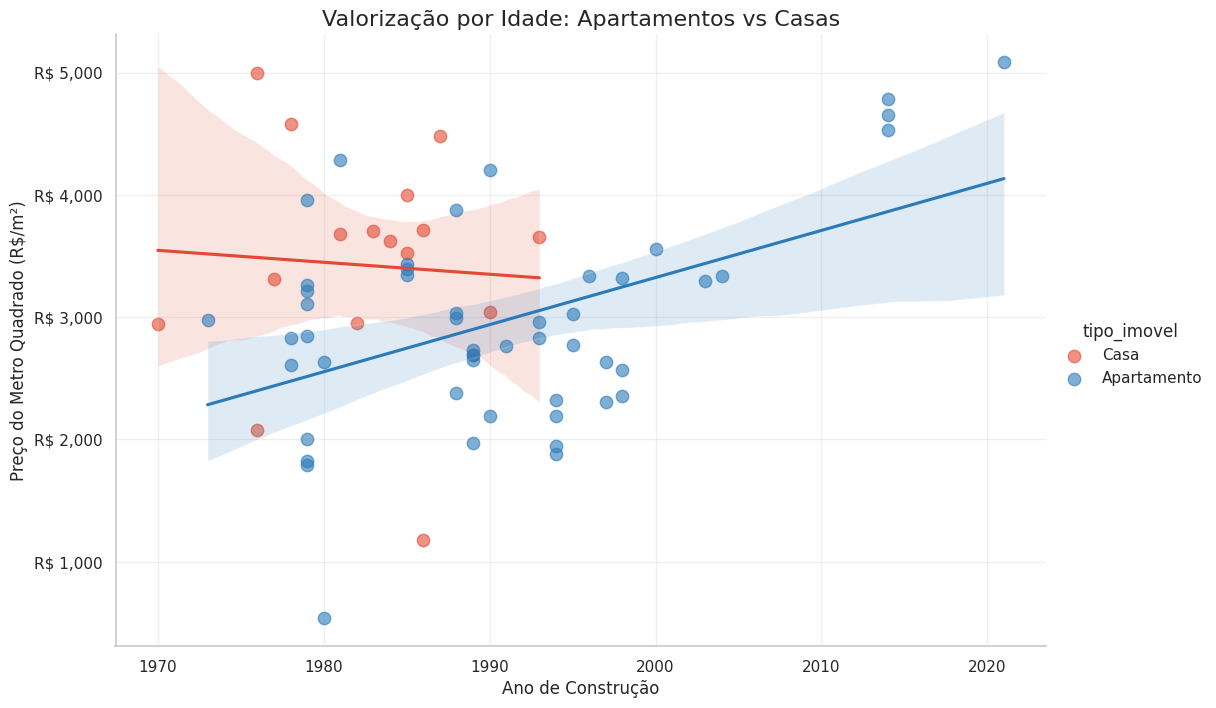


Resumo de Preço Médio (m²) por Década:


In [33]:
# ==============================================================================
# ANÁLISE DE SAFRA (Idade x Preço)
#
# Objetivo: Identificar se imóveis mais novos têm um prêmio de preço (valorização)
# em relação aos antigos, separando a tendência para Casas e Apartamentos.
# ==============================================================================

def analisar_safra(df):
    # 1. Preparação e Filtros
    # Foca apenas em residencial e garante que temos o ano de construção
    df_safra = df[
        (df['tipo_imovel'].isin(['Apartamento', 'Casa'])) &
        (df['acc_final'].notna())
    ].copy()

    # Converte ano para número e remove ruídos (ex: anos 0 ou futuros)
    df_safra['ano_construcao'] = pd.to_numeric(df_safra['acc_final'], errors='coerce')
    ano_atual = pd.Timestamp.now().year

    df_safra = df_safra[
        (df_safra['ano_construcao'] >= 1950) &
        (df_safra['ano_construcao'] <= ano_atual + 2) &
        (df_safra['preco_m2'] > 500)  # Remove valores simbólicos
    ]

    if df_safra.empty:
        print("Dados insuficientes de ano de construção para análise.")
        return

    # 2. Visualização Gráfica (Scatter + Regressão)
    plt.figure(figsize=(12, 8))

    # lmplot cria o gráfico de dispersão com a linha de tendência automática
    g = sns.lmplot(
        data=df_safra,
        x='ano_construcao',
        y='preco_m2',
        hue='tipo_imovel',
        height=7,
        aspect=1.5,
        palette={'Apartamento': '#2b7bba', 'Casa': '#e34a33'},
        scatter_kws={'s': 80, 'alpha': 0.6}
    )

    plt.title('Valorização por Idade: Apartamentos vs Casas', fontsize=16)
    plt.xlabel('Ano de Construção', fontsize=12)
    plt.ylabel('Preço do Metro Quadrado (R$/m²)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Formata eixo Y para moeda (R$)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "R$ {:,.0f}".format(x)))

    plt.show()

    # 3. Tabela Resumo por Década
    df_safra['decada'] = (df_safra['ano_construcao'] // 10 * 10).astype(int)
    resumo = df_safra.groupby(['decada', 'tipo_imovel'])['preco_m2'].agg(['mean', 'count']).unstack()

    print("\nResumo de Preço Médio (m²) por Década:")
    # Formatação condicional para facilitar a leitura
    display(resumo.style
        .format("R$ {:,.2f}", subset=[col for col in resumo.columns if col[0] == 'mean'])
        .format("{:.0f}", subset=[col for col in resumo.columns if col[0] == 'count'])
        .background_gradient(cmap='Reds', axis=None)
    )

# Execução
analisar_safra(df_analise)

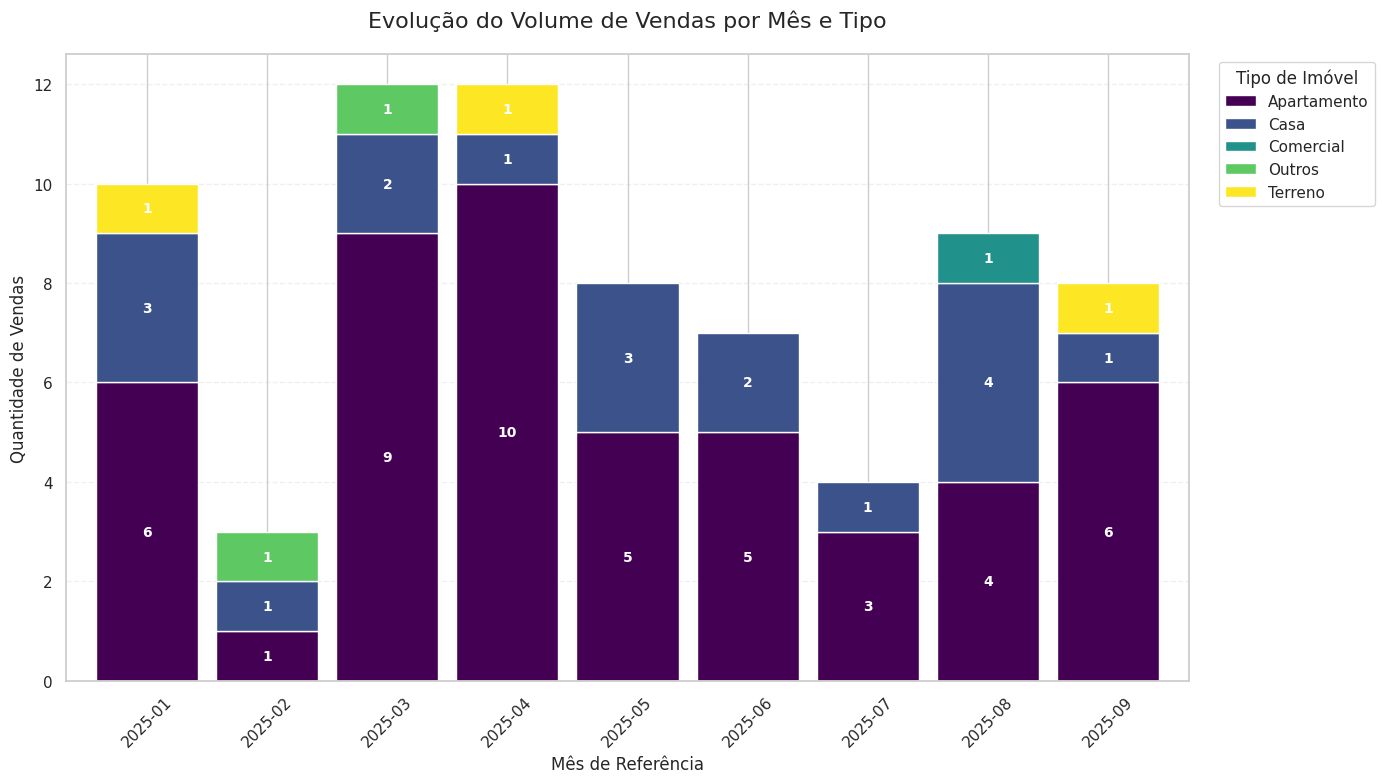


>>> Tabela de Vendas Mensais:


tipo_imovel,Apartamento,Casa,Comercial,Outros,Terreno
mes_ano,,,,,
2025-01,6,3,0,0,1
2025-02,1,1,0,1,0
2025-03,9,2,0,1,0
2025-04,10,1,0,0,1
2025-05,5,3,0,0,0
2025-06,5,2,0,0,0
2025-07,3,1,0,0,0
2025-08,4,4,1,0,0
2025-09,6,1,0,0,1


In [40]:
# ==============================================================================
# VISUALIZAÇÃO: EVOLUÇÃO MENSAL DE VENDAS (EMPILHADO POR TIPO)
#
# O QUE FAZ:
# 1. Agrupa as vendas por Mês e Tipo de Imóvel.
# 2. Gera um gráfico de barras empilhadas para mostrar o volume total e a proporção.
# 3. Adiciona rótulos de dados para facilitar a leitura.
# ==============================================================================

import matplotlib.pyplot as plt
import pandas as pd

def plotar_evolucao_vendas_empilhada(df):
    # Garante que a data está no formato correto
    df_plot = df.copy()
    df_plot['datadetransacao'] = pd.to_datetime(df_plot['datadetransacao'], errors='coerce')
    
    # 1. Preparação dos Dados
    # Cria coluna de Mês/Ano para ordenação cronológica
    df_plot['mes_ano'] = df_plot['datadetransacao'].dt.to_period('M')
    
    # Pivota os dados: Linhas=Meses, Colunas=Tipos, Valores=Contagem
    vendas_mes_tipo = df_plot.groupby(['mes_ano', 'tipo_imovel']).size().unstack(fill_value=0)
    
    if vendas_mes_tipo.empty:
        print("Não há dados suficientes para gerar o gráfico temporal.")
        return

    # 2. Plotagem (Barras Empilhadas)
    ax = vendas_mes_tipo.plot(
        kind='bar',
        stacked=True,
        figsize=(14, 8),
        colormap='viridis',  # Paleta de cores moderna
        edgecolor='white',   # Linha branca entre os blocos para destacar
        width=0.85
    )

    # 3. Estilização
    plt.title('Evolução do Volume de Vendas por Mês e Tipo', fontsize=16, pad=20)
    plt.xlabel('Mês de Referência', fontsize=12)
    plt.ylabel('Quantidade de Vendas', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Tipo de Imóvel', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # 4. Rótulos de Dados (Números dentro das barras)
    for container in ax.containers:
        # Só mostra o número se houver vendas (>0) para não poluir
        labels = [int(v) if v > 0 else '' for v in container.datavalues]
        ax.bar_label(container, labels=labels, label_type='center', color='white', fontweight='bold', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Exibe a tabela crua logo abaixo para conferência
    print("\n>>> Tabela de Vendas Mensais:")
    display(vendas_mes_tipo)

# Executa
plotar_evolucao_vendas_empilhada(df_analise)

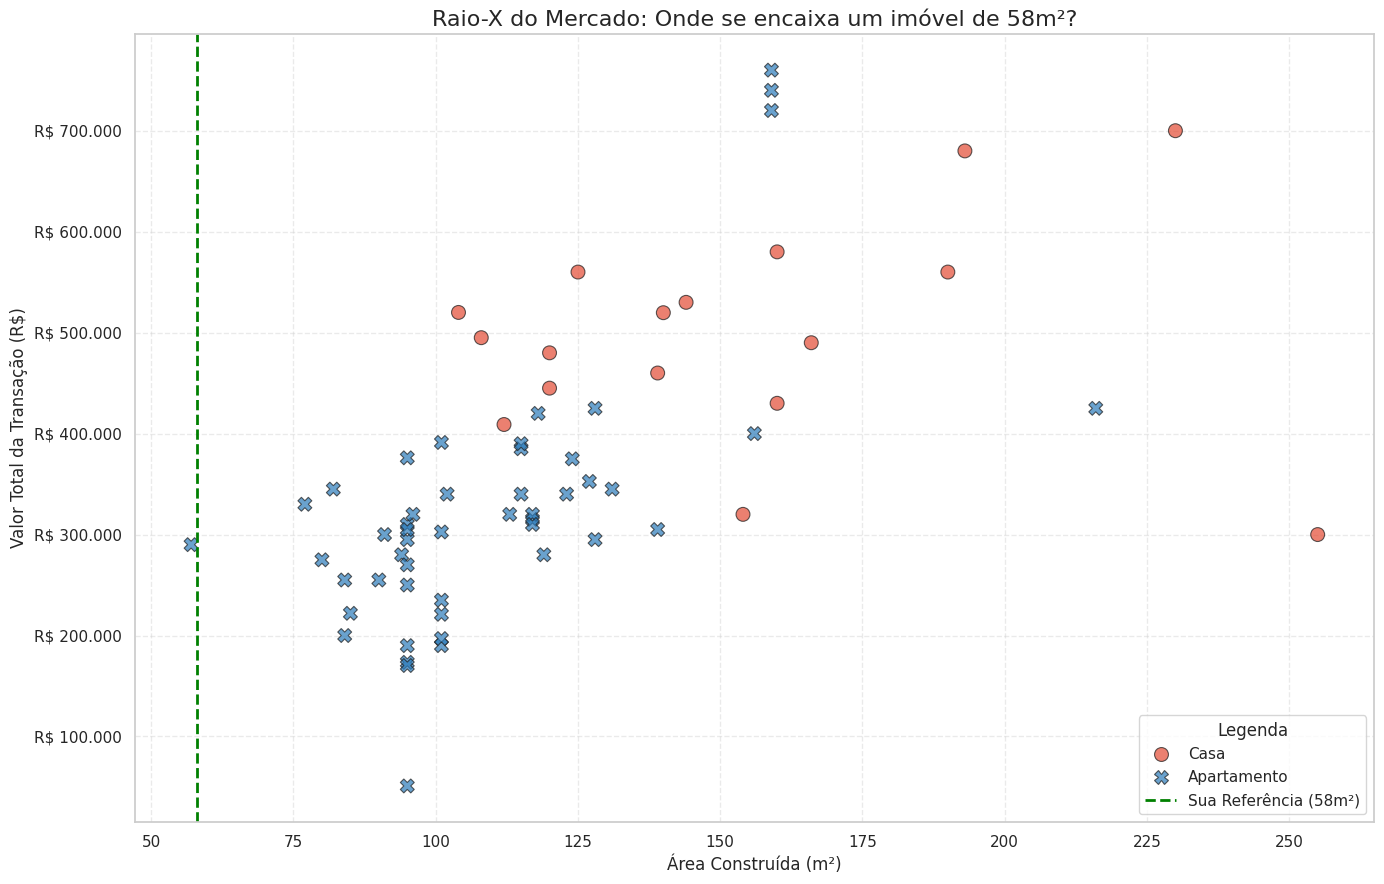

In [34]:
# ==============================================================================
# MAPA DE PREÇOS (DISPERSÃO GERAL)
#
# Objetivo: Visualizar a correlação entre Tamanho e Preço Total.
# Permite identificar se o imóvel alvo está barato ou caro em relação aos vizinhos.
# ==============================================================================

import matplotlib.ticker as ticker

# --- PARÂMETRO: DEFINE A ÁREA DO SEU IMÓVEL AQUI ---
SUA_AREA = 58  # Exemplo: 58m²

def plotar_dispersao(df, area_alvo):
    # Filtra para focar no mercado residencial comum (até 300m²)
    # Remove outliers extremos para melhorar a visualização
    df_plot = df[
        (df['tipo_imovel'].isin(['Apartamento', 'Casa'])) &
        (df['valordetransacaodeclaradopelocontribuinte'] > 50000) &
        (df['areaconstruidam2'] < 300)
    ].copy()

    if df_plot.empty:
        print("Dados insuficientes para o gráfico de dispersão.")
        return

    plt.figure(figsize=(14, 9))

    # Plota os pontos (Transações Reais)
    sns.scatterplot(
        data=df_plot,
        x='areaconstruidam2',
        y='valordetransacaodeclaradopelocontribuinte',
        hue='tipo_imovel',
        style='tipo_imovel',   # Formas diferentes ajudam na leitura
        palette={'Apartamento': '#2b7bba', 'Casa': '#e34a33'},
        s=100,                 # Tamanho do ponto
        alpha=0.7,             # Transparência
        edgecolor='k'          # Borda para destaque
    )

    # Linha de Referência do SEU IMÓVEL
    plt.axvline(area_alvo, color='green', linestyle='--', linewidth=2,
                label=f'Sua Referência ({area_alvo}m²)')

    # Títulos e Labels
    plt.title(f'Raio-X do Mercado: Onde se encaixa um imóvel de {area_alvo}m²?', fontsize=16)
    plt.xlabel('Área Construída (m²)', fontsize=12)
    plt.ylabel('Valor Total da Transação (R$)', fontsize=12)

    # Formata o Eixo Y para dinheiro (R$)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: 'R$ {:,.0f}'.format(x).replace(',', '.')))

    plt.legend(title='Legenda', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# Execução
plotar_dispersao(df_analise, SUA_AREA)

>>> Gerando Ranking de Valorização: APARTAMENTOS...


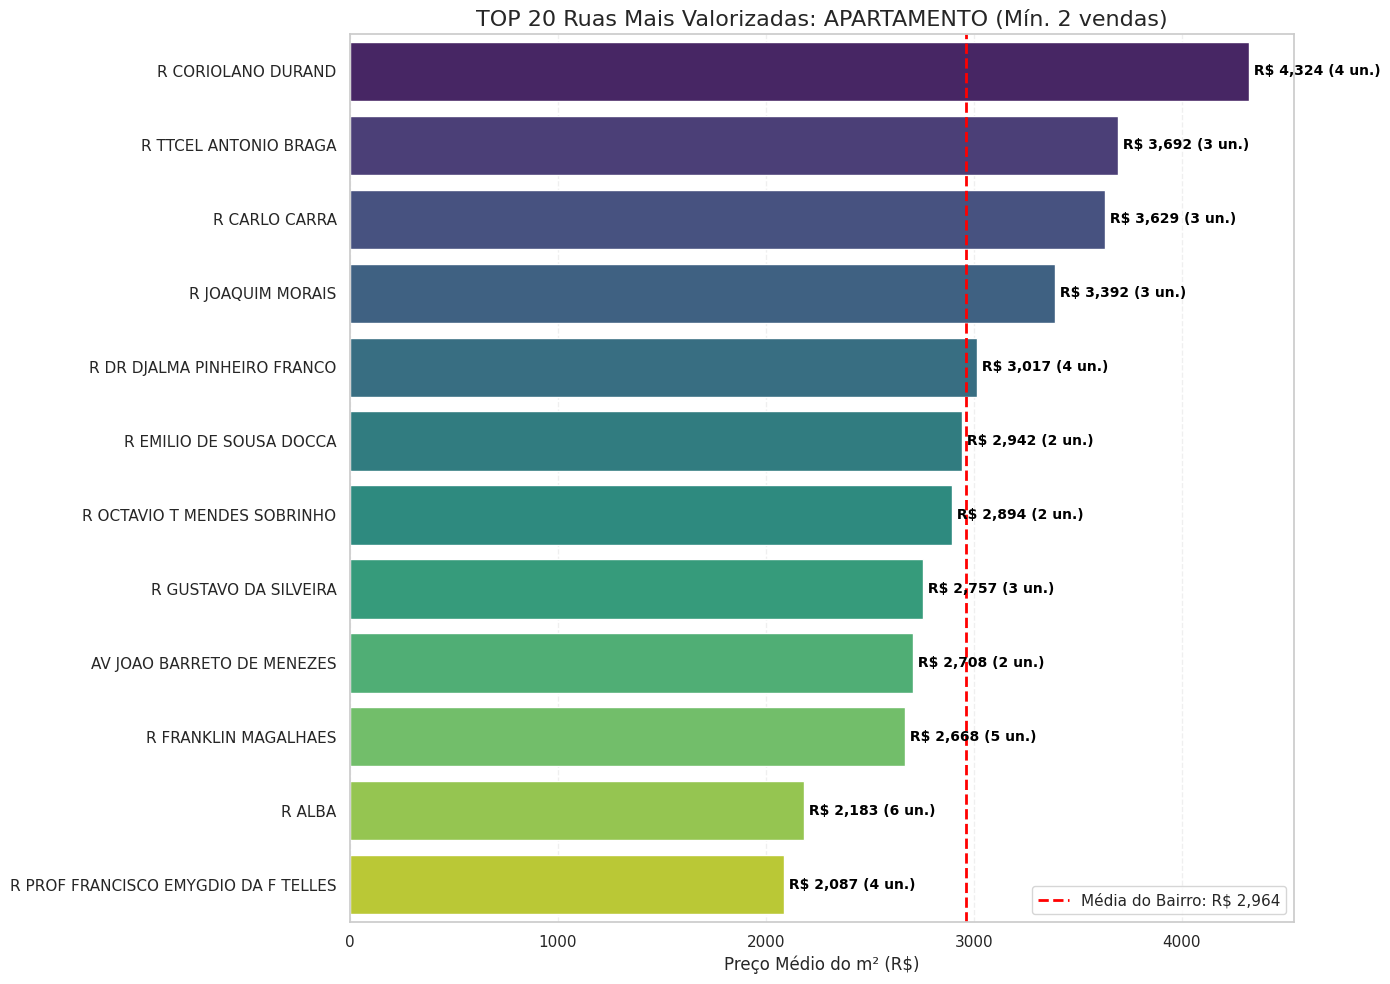


>>> Gerando Ranking de Valorização: CASAS...


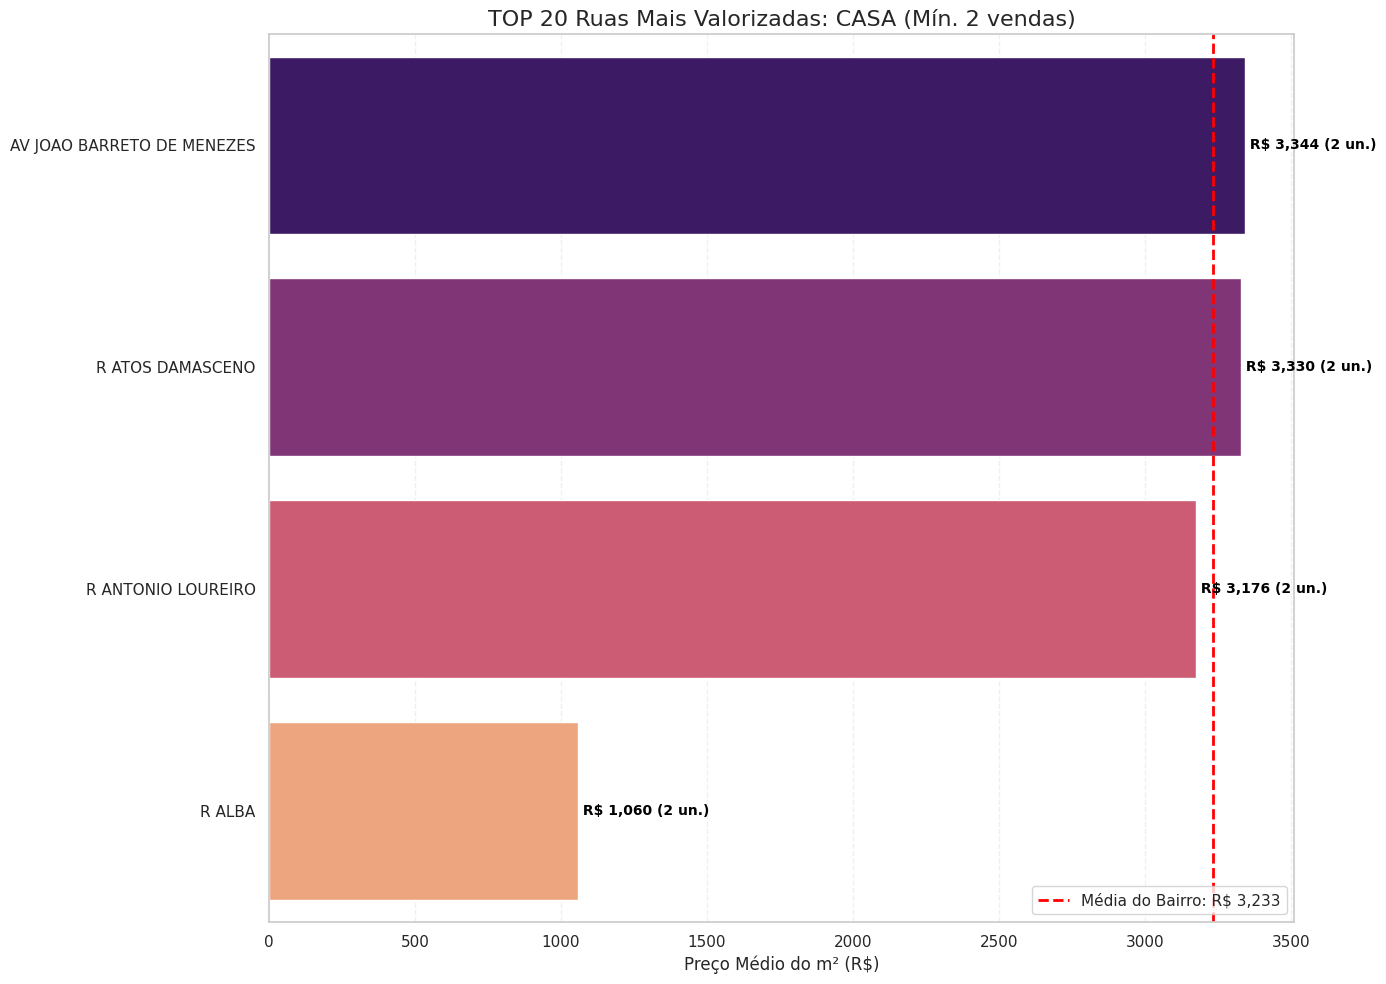

In [35]:
# ==============================================================================
# RANKING TOP 20 RUAS MAIS VALORIZADAS (CORRIGIDO)
#
# O QUE FAZ:
# 1. Agrupa por rua e calcula o preço médio.
# 2. Filtra ruas com menos de 2 vendas.
# 3. Plota barras coloridas.
# 4. Escreve manualmente o PREÇO e QUANTIDADE ao lado de cada barra (sem erro).
# ==============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plotar_ranking_ruas(df_input, tipo_imovel, cor_barra):
    # Filtra pelo tipo de imóvel
    df_tipo = df_input[df_input['tipo_imovel'] == tipo_imovel].copy()
    
    # Agrupa e calcula
    stats_rua = df_tipo.groupby('logradouro_norm').agg({
        'preco_m2': 'mean',
        'valordetransacaodeclaradopelocontribuinte': 'count'
    }).rename(columns={'valordetransacaodeclaradopelocontribuinte': 'Qtd'})
    
    # Filtro de Relevância (Mín 2 vendas)
    stats_rua = stats_rua[stats_rua['Qtd'] >= 2]
    
    # Top 20
    top_20 = stats_rua.sort_values(by='preco_m2', ascending=False).head(20)
    
    if top_20.empty:
        print(f"Dados insuficientes para {tipo_imovel} (mín. 2 vendas por rua).")
        return

    # --- PLOTAGEM ---
    plt.figure(figsize=(14, 10)) # Aumentei a largura para caber o texto
    
    ax = sns.barplot(
        x=top_20['preco_m2'], 
        y=top_20.index, 
        palette=cor_barra,
        hue=top_20.index, 
        legend=False
    )
    
    # Linha de Média
    media_cat = df_tipo['preco_m2'].mean()
    plt.axvline(media_cat, color='red', linestyle='--', linewidth=2, label=f'Média do Bairro: R$ {media_cat:,.0f}')
    
    # Títulos
    plt.title(f'TOP 20 Ruas Mais Valorizadas: {tipo_imovel.upper()} (Mín. 2 vendas)', fontsize=16)
    plt.xlabel('Preço Médio do m² (R$)', fontsize=12)
    plt.ylabel(None)
    plt.legend(loc='lower right')
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    
    # --- ETIQUETAS (CORREÇÃO ROBUSTA) ---
    # Escreve o texto manualmente em cada posição Y
    for i, (rua, row) in enumerate(top_20.iterrows()):
        preco = row['preco_m2']
        qtd = row['Qtd']
        texto = f" R$ {preco:,.0f} ({int(qtd)} un.)"
        
        # ax.text(x, y, texto, alinhamento_vertical)
        ax.text(
            x=preco, 
            y=i, 
            s=texto, 
            va='center', 
            fontweight='bold', 
            fontsize=10,
            color='black'
        )

    plt.tight_layout()
    plt.show()

# --- EXECUÇÃO ---

# 1. Ranking de APARTAMENTOS
print(">>> Gerando Ranking de Valorização: APARTAMENTOS...")
plotar_ranking_ruas(df_analise, 'Apartamento', 'viridis')

# 2. Ranking de CASAS
print("\n>>> Gerando Ranking de Valorização: CASAS...")
plotar_ranking_ruas(df_analise, 'Casa', 'magma')

>>> Gerando Perfil Financeiro e Jurídico...


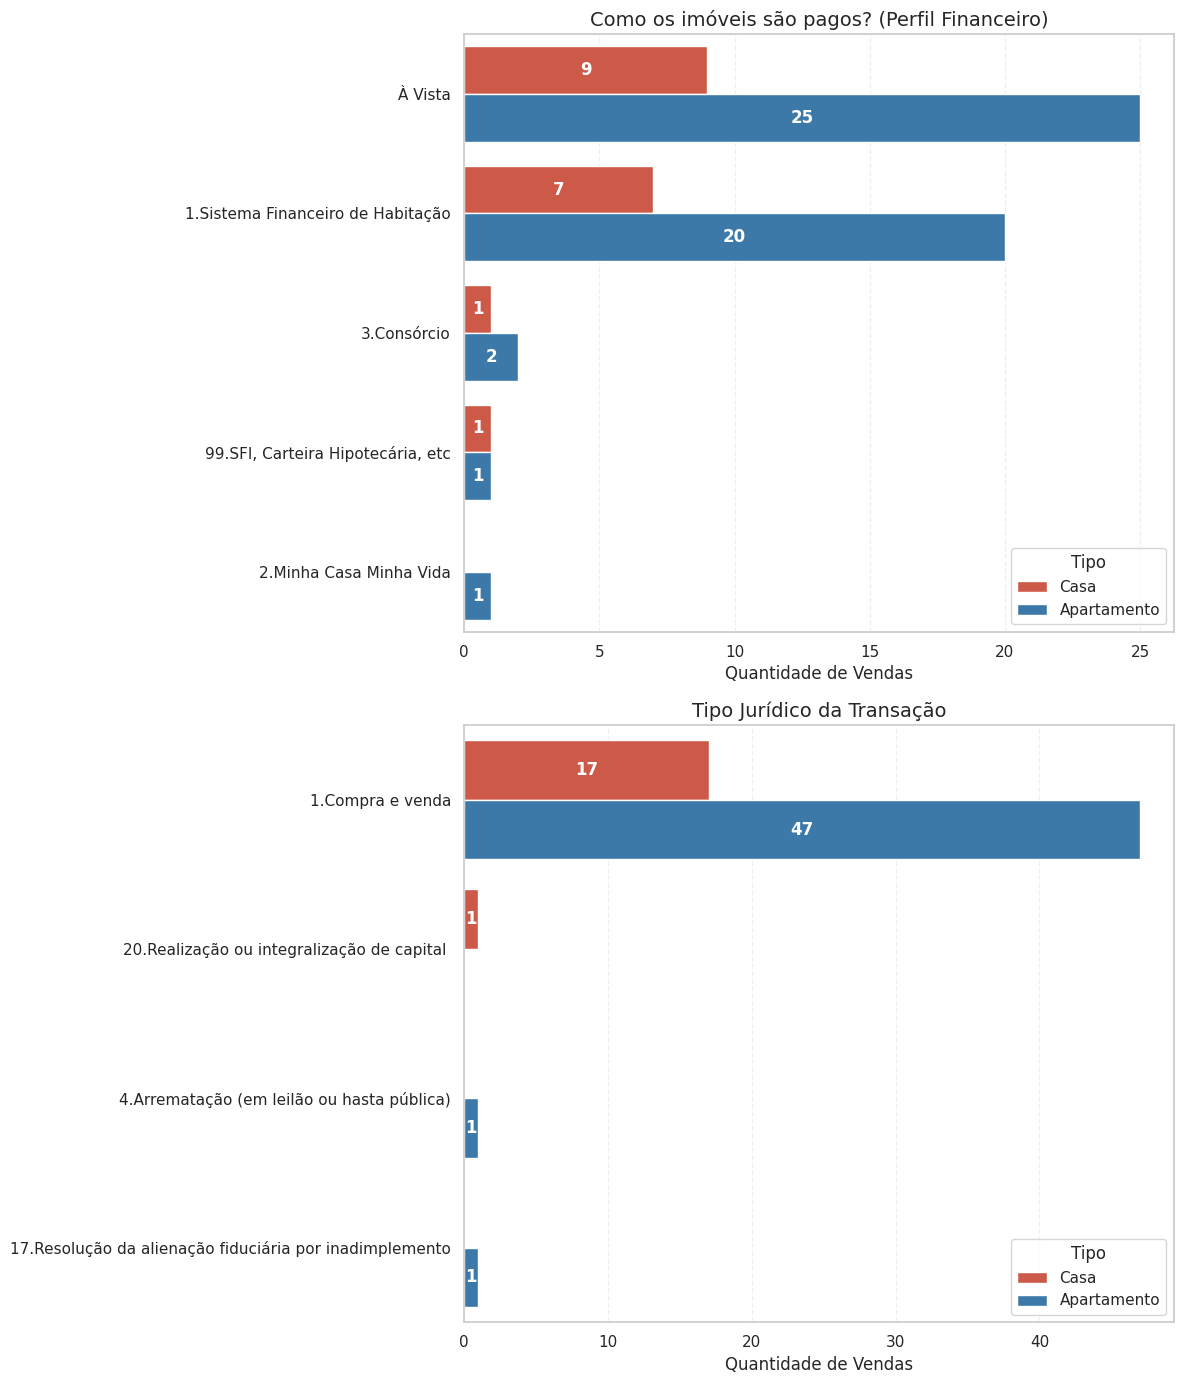

In [36]:
# ==============================================================================
# PERFIL FINANCEIRO E JURÍDICO
#
# Objetivo: Entender como os imóveis são pagos (Financiamento vs À Vista)
# e qual a natureza jurídica das transações (Compra e Venda, Doação, etc.)
# ==============================================================================

def analisar_perfil_transacoes(df):
    # Filtra apenas o mercado residencial relevante
    df_plot = df[df['tipo_imovel'].isin(['Apartamento', 'Casa'])].copy()

    if df_plot.empty:
        print("Dados insuficientes para análise financeira.")
        return

    # Tratamento de Nulos: Vazio no financiamento geralmente indica pagamento à vista
    df_plot['tipodefinanciamento'] = df_plot['tipodefinanciamento'].fillna('À Vista')

    # Configuração da Figura (2 gráficos lado a lado ou empilhados)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))
    
    # Cores padrão
    paleta = {'Apartamento': '#2b7bba', 'Casa': '#e34a33'}

    # --- GRÁFICO 1: FORMA DE PAGAMENTO ---
    sns.countplot(
        data=df_plot,
        y='tipodefinanciamento', 
        hue='tipo_imovel',
        palette=paleta,
        ax=ax1,
        order=df_plot['tipodefinanciamento'].value_counts().index 
    )
    ax1.set_title('Como os imóveis são pagos? (Perfil Financeiro)', fontsize=14)
    ax1.set_xlabel('Quantidade de Vendas')
    ax1.set_ylabel(None)
    ax1.legend(title='Tipo')
    ax1.grid(axis='x', linestyle='--', alpha=0.3)
    
    # Rótulos (Números nas barras)
    for container in ax1.containers:
        labels = [f'{v:.0f}' if v > 0 else '' for v in container.datavalues]
        ax1.bar_label(container, labels=labels, label_type='center', color='white', fontweight='bold')

    # --- GRÁFICO 2: NATUREZA DA TRANSAÇÃO ---
    # Filtra as Top 8 naturezas para o gráfico não ficar poluído com tipos raros
    top_naturezas = df_plot['naturezadetransacao'].value_counts().head(8).index
    df_natureza = df_plot[df_plot['naturezadetransacao'].isin(top_naturezas)]

    sns.countplot(
        data=df_natureza,
        y='naturezadetransacao',
        hue='tipo_imovel',
        palette=paleta,
        ax=ax2,
        order=top_naturezas
    )
    ax2.set_title('Tipo Jurídico da Transação', fontsize=14)
    ax2.set_xlabel('Quantidade de Vendas')
    ax2.set_ylabel(None)
    ax2.legend(title='Tipo')
    ax2.grid(axis='x', linestyle='--', alpha=0.3)
    
    # Rótulos
    for container in ax2.containers:
        labels = [f'{v:.0f}' if v > 0 else '' for v in container.datavalues]
        ax2.bar_label(container, labels=labels, label_type='center', color='white', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Execução
print(">>> Gerando Perfil Financeiro e Jurídico...")
analisar_perfil_transacoes(df_analise)

In [37]:
# ==============================================================================
# MOTOR DE GEOCODIFICAÇÃO (CONVERSÃO ENDEREÇO -> GPS)
#
# Objetivo: Buscar Latitude e Longitude para cada imóvel.
# Estratégia: Tenta endereço exato -> Tenta sem bairro -> Tenta só rua.
# ==============================================================================

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
from tqdm.notebook import tqdm
import time
import re

def limpar_para_busca(texto):
    """Prepara o texto para aumentar chances de match no OpenStreetMap"""
    if pd.isna(texto): return ""
    t = str(texto)
    # Expande abreviações comuns
    t = re.sub(r'\bR\b', 'RUA', t, flags=re.IGNORECASE) 
    t = re.sub(r'\bAV\b', 'AVENIDA', t, flags=re.IGNORECASE)
    return t

def buscar_coordenadas_smart(df_input):
    df_geo = df_input.copy()
    
    # Cria colunas auxiliares para busca
    df_geo['logradouro_busca'] = df_geo['nomedologradouro'].apply(limpar_para_busca)
    df_geo['bairro_busca'] = df_geo['bairro'].apply(limpar_para_busca)
    df_geo['numero_busca'] = df_geo['numero'].astype(str)
    
    # Identifica endereços ÚNICOS para não buscar o mesmo prédio 50 vezes
    # (Economiza tempo e recursos da API)
    chaves_unicas = df_geo[['logradouro_busca', 'numero_busca', 'bairro_busca']].drop_duplicates()
    
    print(f">>> Total de endereços únicos para buscar: {len(chaves_unicas)}")
    
    # Configuração do Geocoder (Nominatim é gratuito)
    geolocator = Nominatim(user_agent="analise_imob_sp_v2")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1.2) # Delay seguro
    
    cache_coords = {}
    
    # Função interna de tentativa segura
    def tentar_geo(query):
        try:
            return geocode(query, timeout=10)
        except (GeocoderTimedOut, GeocoderUnavailable):
            time.sleep(2)
            return None
        except Exception:
            return None

    # Loop com Barra de Progresso Visual
    print("Iniciando mapeamento...")
    for _, row in tqdm(chaves_unicas.iterrows(), total=len(chaves_unicas), desc="Mapeando"):
        
        rua = row['logradouro_busca']
        num = row['numero_busca']
        bairro = row['bairro_busca']
        
        chave_cache = f"{rua}_{num}"
        
        # Estratégia 1: Completa (Rua, Número, Bairro)
        loc = tentar_geo(f"{rua}, {num}, {bairro}, SÃO PAULO, BRAZIL")
        
        # Estratégia 2: Sem Bairro (Às vezes o bairro oficial difere do mapa)
        if not loc:
            loc = tentar_geo(f"{rua}, {num}, SÃO PAULO, BRAZIL")
            
        # Estratégia 3: Só Rua (Aproximação pelo centro da via)
        if not loc:
            loc = tentar_geo(f"{rua}, SÃO PAULO, BRAZIL")
            
        # Armazena no cache
        if loc:
            cache_coords[chave_cache] = (loc.latitude, loc.longitude)
        else:
            cache_coords[chave_cache] = (None, None)
            
    # Aplica os resultados no DataFrame original
    print("\n>>> Aplicando coordenadas encontradas...")
    
    def get_lat_lon(row):
        chave = f"{row['logradouro_busca']}_{row['numero_busca']}"
        return cache_coords.get(chave, (None, None))

    coords = df_geo.apply(get_lat_lon, axis=1)
    df_geo['Latitude'] = [x[0] for x in coords]
    df_geo['Longitude'] = [x[1] for x in coords]
    
    # Filtra apenas o que foi encontrado
    df_final = df_geo.dropna(subset=['Latitude', 'Longitude'])
    
    print(f">>> Sucesso! {len(df_final)} imóveis mapeados.")
    print(f">>> Perdidos: {len(df_geo) - len(df_final)}")
    
    return df_final

# Executa
df_mapa = buscar_coordenadas_smart(df_analise)

>>> Total de endereços únicos para buscar: 49
Iniciando mapeamento...


Mapeando:   0%|          | 0/49 [00:00<?, ?it/s]


>>> Aplicando coordenadas encontradas...
>>> Sucesso! 62 imóveis mapeados.
>>> Perdidos: 11


In [38]:
# ==============================================================================
# MAPA INTERATIVO (FOLIUM)
#
# Objetivo: Plotar os imóveis no mapa para análise espacial.
# Requisito: Ter executado o bloco anterior (Geocodificação) para gerar 'df_mapa'.
# ==============================================================================

import folium
from folium.plugins import MarkerCluster

def gerar_mapa_vendas(df_geo, df_original):
    # 1. Auditoria de Sucesso
    total = len(df_original)
    encontrados = len(df_geo)
    print(f"=== RELATÓRIO DE MAPEAMENTO ===")
    print(f"Imóveis com endereço localizado: {encontrados} de {total} ({(encontrados/total):.1%} de sucesso)")
    
    if df_geo.empty:
        print("ERRO: Não há coordenadas para plotar.")
        return None

    # 2. Configuração do Mapa
    # Centraliza na média das coordenadas encontradas
    centro_lat = df_geo['Latitude'].mean()
    centro_lon = df_geo['Longitude'].mean()
    
    mapa = folium.Map(location=[centro_lat, centro_lon], zoom_start=15, tiles='OpenStreetMap')
    
    # Clusterização (agrupa pontos próximos para não poluir a visão)
    marker_cluster = MarkerCluster().add_to(mapa)
    
    # 3. Adição dos Pontos
    for _, row in df_geo.iterrows():
        
        # Define cor e ícone
        tipo = row.get('tipo_imovel', 'Outros')
        if tipo == 'Apartamento':
            cor, icone = 'blue', 'building'
        elif tipo == 'Casa':
            cor, icone = 'red', 'home'
        else:
            cor, icone = 'gray', 'info-sign'
            
        # Informações do Popup (HTML)
        texto_popup = f"""
        <b>{tipo}</b><br>
        Endereço: {row['nomedologradouro']}, {row['numero']}<br>
        Área: {row['areaconstruidam2']:.0f} m²<br>
        Valor: R$ {row['valordetransacaodeclaradopelocontribuinte']:,.2f}<br>
        Data: {row['datadetransacao'].strftime('%d/%m/%Y')}
        """
        
        # Tooltip simples (passar o mouse)
        texto_tooltip = f"{tipo} - {row['areaconstruidam2']:.0f}m² (R$ {row['valordetransacaodeclaradopelocontribuinte']:,.0f})"
        
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=folium.Popup(texto_popup, max_width=300),
            tooltip=texto_tooltip,
            icon=folium.Icon(color=cor, icon=icone)
        ).add_to(marker_cluster)
        
    return mapa

# Execução
print(">>> Gerando mapa...")
mapa = gerar_mapa_vendas(df_mapa, df_analise)

# Exibe no notebook
display(mapa)

# Salva em arquivo (opcional)
mapa.save("mapa_imoveis_vila_santa_catarina.html")
print(">>> Arquivo 'mapa_imoveis_vila_santa_catarina.html' salvo com sucesso.")

>>> Gerando mapa...
=== RELATÓRIO DE MAPEAMENTO ===
Imóveis com endereço localizado: 62 de 73 (84.9% de sucesso)


>>> Arquivo 'mapa_imoveis_vila_santa_catarina.html' salvo com sucesso.


In [39]:
# ==============================================================================
# EXPORTAÇÃO FINAL (ARQUIVO CSV COMPLETO)
#
# Objetivo: Salvar o dataset tratado com todas as colunas originais e enriquecidas.
# - Mantém TODAS as colunas (ndocadastrosql, matricula, etc).
# - Integra coordenadas do mapa (se disponíveis).
# - Renomeia apenas as colunas principais para facilitar leitura no Excel.
# ==============================================================================

print(">>> Preparando arquivo final para exportação...")

# 1. Criação de cópia de segurança para não alterar a análise
df_export = df_analise.copy()

# 2. Integração de Coordenadas (Latitude/Longitude)
# Verifica se o mapeamento foi feito anteriormente
if 'df_mapa' in locals() and not df_mapa.empty:
    print(">>> Integrando coordenadas geográficas...")
    # Mapeia pelo índice para garantir a linha exata
    df_export['Latitude'] = df_export.index.map(df_mapa['Latitude'].to_dict())
    df_export['Longitude'] = df_export.index.map(df_mapa['Longitude'].to_dict())
else:
    print(">>> [AVISO] Base de mapa não encontrada. O arquivo seguirá sem colunas de GPS.")

# 3. Remoção de coluna inconsistente (Solicitado)
if 'qtd_vagas' in df_export.columns:
    df_export = df_export.drop(columns=['qtd_vagas'])
    print(">>> Coluna 'qtd_vagas' removida.")

# 4. Ordenação Cronológica (Mais recente primeiro)
if 'datadetransacao' in df_export.columns:
    df_export = df_export.sort_values(by='datadetransacao', ascending=False)

# 5. Renomeação Amigável (Apenas colunas chave)
# As colunas que NÃO estão nesta lista (como 'matriculadoimovel') serão mantidas com o nome original.
mapa_nomes = {
    'datadetransacao': 'Data Venda',
    'tipo_imovel': 'Tipo',
    'nomedologradouro': 'Endereço',
    'numero': 'Número',
    'complemento_norm': 'Complemento',
    'areaconstruidam2': 'Área Útil (m²)',
    'valordetransacaodeclaradopelocontribuinte': 'Valor Venda (Total)',
    'preco_m2': 'Preço m²',
    'acc_final': 'Ano Construção',
    'status_fusao': 'Status Fusão',
    'tipodefinanciamento': 'Financiamento',
    'naturezadetransacao': 'Natureza',
    'bairro': 'Bairro'
}
df_export = df_export.rename(columns=mapa_nomes)

# 6. Salvando o Arquivo
nome_arquivo = 'Relatorio_Final_Mercado_Imobiliario.csv'

df_export.to_csv(
    nome_arquivo, 
    index=False, 
    sep=';',             # Padrão Brasileiro/Excel
    decimal=',',         # Decimal brasileiro
    encoding='utf-8-sig' # Garante acentos (ç, ã, é) corretos no Windows
)

print(f"\n SUCESSO! Processamento concluído.")
print(f" Arquivo salvo: {nome_arquivo}")
print(f" Total de registros: {len(df_export)}")
print(f" Total de colunas: {len(df_export.columns)}")

>>> Preparando arquivo final para exportação...
>>> Integrando coordenadas geográficas...

 SUCESSO! Processamento concluído.
 Arquivo salvo: Relatorio_Final_Mercado_Imobiliario.csv
 Total de registros: 73
 Total de colunas: 41
